In [82]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

API_KEY = "5K2C96PUQWH9YWMX"

In [83]:
# (5)
# opening and storing data

url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=IBM&apikey={API_KEY}'
r = requests.get(url)
data = r.json()

# storing in a dataframe 
df = pd.DataFrame(data['Time Series (Daily)']).T

# resetting index to have dates as a column
df.reset_index(inplace=True)

# renaming the columns
df.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

# converting date column to datetime
df['date'] = pd.to_datetime(df['date'])

# filtering data for specified date range 
# we'll keep the datetime the same rather than turning it into a sequence of numbers
start_date = '2023-11-07'
end_date = '2024-03-26'
df_filtered = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

print(df_filtered)

# splitting into train and test sets (test = first 5 rows)
test = df_filtered.iloc[:5]
train = df_filtered.iloc[5:]


         date      open      high       low     close   volume
23 2024-03-26  189.0200  190.0000  188.5000  188.5000  4229535
24 2024-03-25  190.2600  190.8200  188.7500  188.7900  3718289
25 2024-03-22  192.0000  192.9850  190.5100  190.8400  3988398
26 2024-03-21  193.0000  193.3700  190.0100  191.9000  6013561
27 2024-03-20  192.8700  193.9800  191.3100  193.9600  3238643
..        ...       ...       ...       ...       ...      ...
95 2023-12-11  162.6800  163.6500  161.9500  163.5100  6077207
96 2023-12-08  160.0000  162.0400  160.0000  161.9600  4561342
97 2023-12-07  161.0000  161.4650  159.9700  160.2200  3665498
98 2023-12-06  161.5900  162.3550  160.0100  160.2800  3356432
99 2023-12-05  160.7600  162.4700  160.7200  161.3900  4556668

[77 rows x 6 columns]


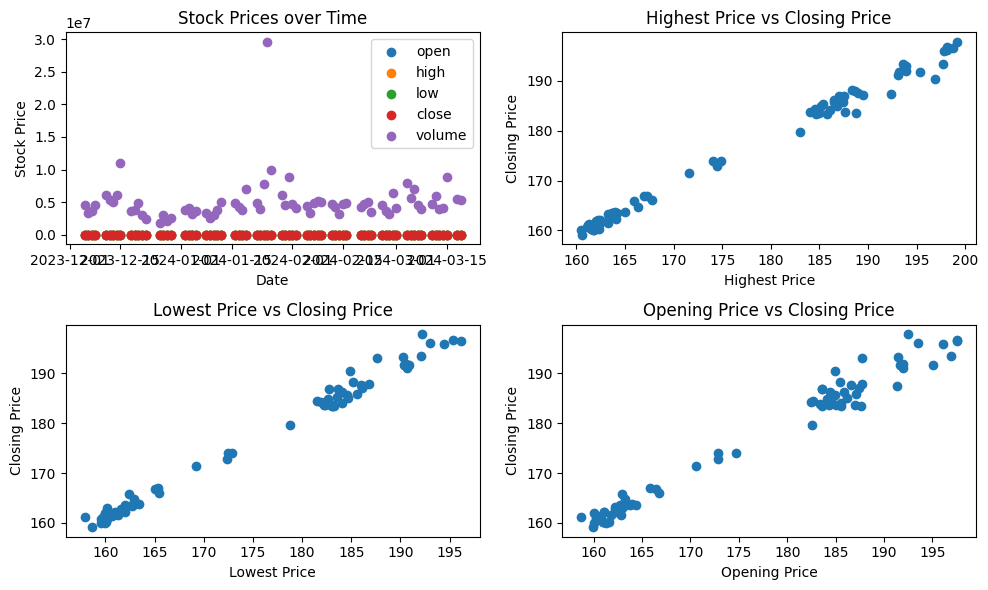

In [84]:
# (10)
# column names excluding date
column_names = ['open', 'high', 'low', 'close', 'volume']

# USING 'TRAIN DATASET FROM NOW ON
# converting prices to numeric values (if they're not already)
train.loc[:, column_names] = train.loc[:, column_names].apply(pd.to_numeric)

# creating subplots for detailed relationships
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# plotting columns against date 
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Stock Price')
axes[0, 0].set_title('Stock Prices over Time')
for column in column_names:
    if column != 'date':
        axes[0, 0].scatter(train['date'], train[column], label=column)
axes[0, 0].legend()

# highest vs closing price
axes[0, 1].scatter(train['high'], train['close'])
axes[0, 1].set_xlabel('Highest Price')
axes[0, 1].set_ylabel('Closing Price')
axes[0, 1].set_title('Highest Price vs Closing Price')

# lowest vs closing price
axes[1, 0].scatter(train['low'], train['close'])
axes[1, 0].set_xlabel('Lowest Price')
axes[1, 0].set_ylabel('Closing Price')
axes[1, 0].set_title('Lowest Price vs Closing Price')

# opening vs closing price
axes[1, 1].scatter(train['open'], train['close'])
axes[1, 1].set_xlabel('Opening Price')
axes[1, 1].set_ylabel('Closing Price')
axes[1, 1].set_title('Opening Price vs Closing Price')

plt.tight_layout()
plt.show()

In [334]:
# (15)
'''
Now that we’ve visualized our data, let's make a few conjectures about what to expect from our linear regression model. 
For each of the variable relationships you graphed above, which of them display a linear relationship? 
Which do not? Why or why not? 
'''

# Answer
'''
Of the graphs above, highest vs closing, lowest vs closing, and opening vs closing all display a linear relationship. 
In these graphs, the points tend to form a roughly straight line, showing a clear trend. 
The clustering of points around a sort of trend line indicate that there's a consistent relationship between the variables being plotted.

The graph displaying the relationship between stock price and date does not display a linear relationship.
The plot illustrates fluctuations, trends, and some irregular patterns over time. 
The data points are scattered across the plot and do not form a clear linear trend. 
It suggests that the relationship between stock price and date is more complex and dynamic, influenced by various factors.
'''

"\nOf the graphs above, highest vs closing, lowest vs closing, and opening vs closing all display a linear relationship. \nIn these graphs, the points tend to form a roughly straight line, showing a clear trend. \nThe clustering of points around a sort of trend line indicate that there's a consistent relationship between the variables being plotted.\n\nThe graph displaying the relationship between stock price and date does not display a linear relationship.\nThe plot illustrates fluctuations, trends, and some irregular patterns over time. \nThe data points are scattered across the plot and do not form a clear linear trend. \nIt suggests that the relationship between stock price and date is more complex and dynamic, influenced by various factors.\n"

high    0.336083
open    0.333049
low     0.330678
ones    0.001879
dtype: object
Bias-> 0.0018791966372498268 , High Weight-> 0.3360826715209205 , Open Weight-> 0.33304865316416066 , Low Weight-> 0.33067832194824903


/var/folders/yp/tstkjj2n2g17srbbpcfn09ch0000gn/T/ipykernel_36142/3501603674.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newR['ones'] = np.ones(len(train))
/var/folders/yp/tstkjj2n2g17srbbpcfn09ch0000gn/T/ipykernel_36142/3501603674.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Bias->",theta[3],", High Weight->",theta[0],", Open Weight->",theta[1],", Low Weight->",theta[2])


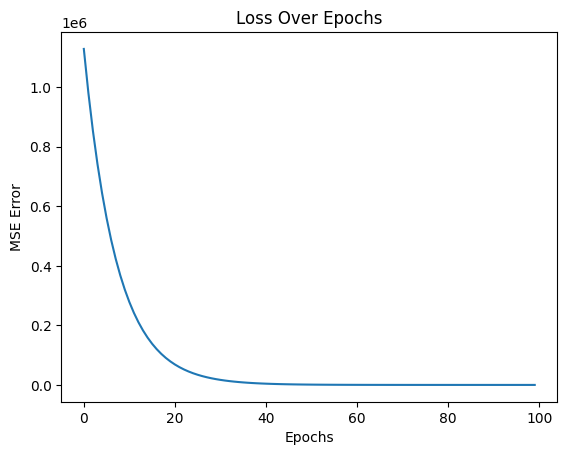

In [85]:
# (20)
newR = train[['high', 'open', 'low']]
newR['ones'] = np.ones(len(train))

# Fit the linear regression model using gradient descent
def grad_descent(X, y, T, alpha):
    m, n = X.shape
    theta = np.zeros(n)
    f = np.zeros(T)
    for i in range(T):
        f[i] = 0.5 * np.linalg.norm(X.dot(theta) - y) ** 2
        g = np.transpose(X).dot(X.dot(theta) - y)
        theta = theta - alpha * g
    return theta, f

y = train['close'] # Dependent variable (close)

# Gradient Descent Parameters
T1 = 100
alpha1 = 0.00000001

# Fit the linear regression model using gradient descent
theta, func = grad_descent(newR, y, T1, alpha1) # regression for high and close

print(theta)

print("Bias->",theta[3],", High Weight->",theta[0],", Open Weight->",theta[1],", Low Weight->",theta[2])

plt.plot(range(T1), func)
plt.ylabel("MSE Error")
plt.xlabel("Epochs")
plt.title("Loss Over Epochs")
plt.show()

In [86]:
# (20)
theta = np.array(theta)
x = np.array(test[["high", "open", "low"]].values)
x = x.astype(float)
theta = theta.astype(float)
y = test["close"].values # Dependent variable (close)
y = y.astype(float)
y_h = np.dot(x,theta[:-1]) + theta[-1]
mse = np.mean((y-y_h)**2)
print("Actual Values: ", y)
print ("Predicted Values: ", y_h) 
print("Mean Squared Error: ", mse)

Actual Values:  [188.5  188.79 190.84 191.9  193.96]
Predicted Values:  [189.14330689 189.9145446  191.80366208 192.1007634  192.69235933]
Mean Squared Error:  0.8508615473117567


In [337]:
# (5)
# Adding regularization to a model helps control its complexity by penalizing coefficients not essential for prediction, reducing overfitting. 
# Ridge Regression is useful due to its ability to shrink coefficients towards zero while still allowing all features to contribute to prediction, and it can address multicollinearity issues by reducing the effect of redundant or irrelevant variables.

The predicted and actual values are very close given each corresponding value has a margin of error of at most 2.  Given that information, the lack of differenctiation between the predicted and actual values can resonably infer why the mean squared error value was small.

/var/folders/yp/tstkjj2n2g17srbbpcfn09ch0000gn/T/ipykernel_36142/1168130860.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_quad['high_sq'] = train_quad['high'] ** 2
/var/folders/yp/tstkjj2n2g17srbbpcfn09ch0000gn/T/ipykernel_36142/1168130860.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_quad['open_sq'] = train_quad['open'] ** 2


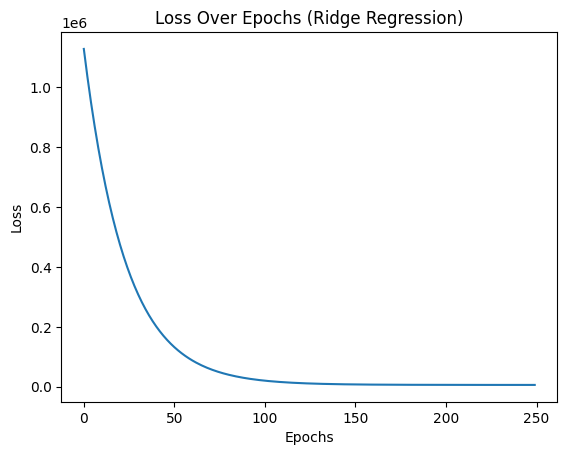

Bias → 6.127183526098561e-08
High Weight → 1.0708453856350073e-05
Open Weight → 1.0619347595812335e-05
Low Weight → 1.0549262342708363e-05


In [87]:
# Adding quadratic terms to the feature matrix
train_quad = train[['high', 'open', 'low']]
train_quad['high_sq'] = train_quad['high'] ** 2
train_quad['open_sq'] = train_quad['open'] ** 2
train_quad['low_sq'] = train_quad['low'] ** 2
train_quad['ones'] = np.ones(len(train))

# Gradient Descent with Ridge Regularization
def grad_descent_ridge(X, y, T, alpha, lambda_val):
    m, n = X.shape
    theta = np.zeros(n)
    f = np.zeros(T)
    for i in range(T):
        loss = 0.5 * np.linalg.norm(X.dot(theta) - y) ** 2  
        regularization = 0.5 * lambda_val * np.linalg.norm(theta) ** 2  
        f[i] = loss + regularization
        g = np.transpose(X).dot(X.dot(theta) - y) + lambda_val * theta
        theta = theta - alpha * g
    return theta, f

# Dependent variable
y = train['close']


# Gradient Descent Parameters
T = 250
alpha2 = 0.0000000000001
lambda_val = 0.01

# Fit the Ridge Regression model using gradient descent
theta_ridge, func_ridge = grad_descent_ridge(train_quad.values, y, T, alpha2, lambda_val)

# Plot loss function over epochs
plt.plot(range(T), func_ridge)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss Over Epochs (Ridge Regression)")
plt.show()

# Extract weights and biases
bias_ridge = theta_ridge[-1]
weights_ridge = theta_ridge[:-1]

print("Bias →", bias_ridge)
print("High Weight →", weights_ridge[0])
print("Open Weight →", weights_ridge[1])
print("Low Weight →", weights_ridge[2])

In [88]:
# (10)
theta_ridge = np.array(theta_ridge)

# Prepare input data
xp = np.array(train_quad.values[:,:-1])
xp = xp.astype(float)
print(theta_ridge.shape)
print(xp.shape)

# Ensure proper data types
theta_ridge = theta_ridge.astype(float)
y = train["close"].values.astype(float)

# Calculate predictions
y_h = np.dot(xp, theta_ridge[:-1]) + theta_ridge[-1]

# Compute Mean Squared Error (MSE)
mse = np.mean((y - y_h) ** 2)

# Print results
print("Actual Values:", y)
print("Predicted Values:", y_h)
print("Mean Squared Error:", mse)
print("The two values may be different because ridge regression prevents overfitting by penalizing big")
print("coefficients which will change the value. Linear regression doesn't have this penalty.")

(7,)
(72, 6)
Actual Values: [193.34 191.69 191.07 193.43 196.7  197.78 191.73 195.95 196.54 196.16
 191.95 193.06 188.2  185.03 185.3  184.87 184.13 185.72 184.21 179.7
 183.44 187.64 186.87 183.57 183.7  186.16 186.34 184.36 183.74 183.41
 183.42 185.79 186.9  183.66 187.87 187.14 187.42 190.43 173.93 173.94
 172.83 171.48 166.84 166.08 166.96 165.8  162.16 161.23 160.08 161.14
 159.16 160.86 160.1  161.5  163.55 163.75 163.46 163.21 162.14 160.78
 160.05 161.56 162.74 162.23 162.91 163.62 164.71 163.51 161.96 160.22
 160.28 161.39]
Predicted Values: [204.4586874  204.38057454 204.72518662 212.73657822 215.69986287
 210.59241326 208.76858916 213.70026263 216.77822918 211.11937028
 205.28469319 200.22473983 193.04061652 192.08282069 189.23742752
 188.12778127 190.77193328 190.86665766 186.10523831 183.03439073
 193.37665903 194.74863193 189.72440576 188.37117462 187.78575472
 191.2069103  190.57790839 185.93493244 186.80242956 187.67993934
 189.92892524 193.74478996 189.49621776 192.22

In [ ]:
# (5)

# We cannot predict accurately every IBM closing day stock value

# Pros of using this approach
# Computationally efficient, can handle large datasets pretty quickly
# Simple and interpretable model, easy to understand and explain
# How you can interpret it, coefficients can show you the impact of each variable

#Cons of using this approach
# May not capture the nonlinear relationships between variables properly
# Sensitive to outlying data which can and will affect the performance of the model
# Assumes a linear relationship between predictors and target variables

# Coefficient for the L2 norm in ridge regression was chosen to fit the balance between bias and variance through
# trial and error. If the lambda is too high or low, the model will overfit or underfit the data  which will neglect
# important patterns and relationships.